In [2]:
# import packages
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 7)
import time

import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

# 3-planet system

Our goal is to derive the inclination precession modes for a 3-planet peas-in-a-pod system with two ways:
1. Numerical simulation + FFT
2. Analytical derivation

For a "more compact" 3-planet example, one could use the masses ($m$) and semimajor axes ($a$) of the Kepler-60 system (see the links below). Otherwise, these two values can be arbitrary within reason (e.g. slightly larger $a$ ratios).
https://aasnova.org/2017/11/20/kepler-planets-tend-to-have-siblings-of-the-same-size/  
https://exoplanets.nasa.gov/exoplanet-catalog/369/kepler-60-b/  
https://exoplanets.nasa.gov/exoplanet-catalog/370/kepler-60-c/  
https://exoplanets.nasa.gov/exoplanet-catalog/371/kepler-60-d/  

We initialize the inclinations so that their relative inclinations are modeled with a Rayleigh distribution with scale 1.8. Later, we will reorient the system so that its total angular momentum axis points along the z-axis (thus changing the inclinations to their "true" values.)  

The values of $e, f,$ and $\omega,$ are initialized with their default values of 0, while $\Omega$ is arbitrary.

# Rebound simulation 

In [5]:
# initialize inclinations (this is *not* in the L_tot frame)
rng = default_rng()
inc_scale = 1.8 * np.pi / 180 # inclination scale in radians

## randomly-generated values
# b_inc_0_rad = rng.rayleigh(scale=inc_scale)
# c_inc_0_rad = rng.rayleigh(scale=inc_scale)
# d_inc_0_rad = rng.rayleigh(scale=inc_scale)

## hard-coded values
b_inc_0_rad = 0.085117750
c_inc_0_rad = 0.045047503
d_inc_0_rad = 0.008071458
print(f'b_inc_0_rad = %.9f' % b_inc_0_rad)
print(f'c_inc_0_rad = %.9f' % c_inc_0_rad)
print(f'd_inc_0_rad = %.9f' % d_inc_0_rad)

b_inc_0_rad = 0.085117750
c_inc_0_rad = 0.045047503
c_inc_0_rad = 0.008071458


We vary the value of $\alpha \equiv a_j / a_{j+1}$; i.e., the semimajor axis ratio of adjacent planets. We sweep from $\alpha = 1/1.3$ through $\alpha = 1/2$.

In [6]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

M_e = 3.00273e-6 # Earth mass in Msun
star_mass = 1.0

# set semimajor axis ratio of adjacent planets
alpha = 1 / 1.3

# Each planet has 4 provided params: mass (m) in Earth masses, semimajor axis (a), 
# inclination (inc), and Omega. The three omitted orbital params (e, f, omega) 
# are left at their default values of 0.
b_params = {
    "m": 4.19 * M_e, 
    "a": 1, 
    "inc": b_inc_0_rad,
    "Omega": 5.3
}

c_params = {
    "m": 3.85 * M_e, 
    "a": b_params['a'] / alpha,
    "inc": c_inc_0_rad,
    "Omega": 2.3
}

d_params = {
    "m": 4.16 * M_e, 
    "a": c_params['a'] / alpha,
    "inc": d_inc_0_rad,
    "Omega": 0.8
}

sim.add(m=star_mass)
sim.add(m=b_params['m'], a=b_params['a'], inc=b_params['inc'], Omega=b_params['Omega'])
sim.add(m=c_params['m'], a=c_params['a'], inc=c_params['inc'], Omega=c_params['Omega'])
sim.add(m=d_params['m'], a=d_params['a'], inc=d_params['inc'], Omega=d_params['Omega'])

# Rotate the axes so that z points along the total angular momentum.
rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum())
sim.rotate(rot)

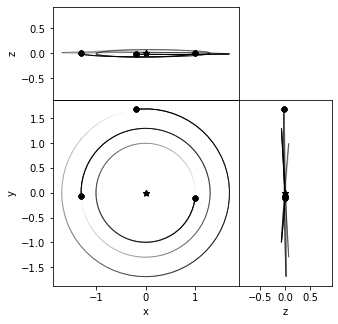

In [8]:
# visualize system before rotation
op_set = rebound.OrbitPlotSet(sim)

In [10]:
## check the particles' inclinations after the frame shift
print(f"Planet B's inc (L_tot frame) = %.9f" % sim.particles[1].inc)
print(f"Planet C's inc (L_tot frame) = %.9f" % sim.particles[2].inc)
print(f"Planet D's inc (L_tot frame) = %.9f" % sim.particles[3].inc)

Planet B's inc (L_tot frame) = 0.074293253
Planet C's inc (L_tot frame) = 0.055922535
Planet D's inc (L_tot frame) = 0.014274379


## Run sim

In [11]:
tstep = 1
tmax = 2**17 # end time of integration (yr)
num_steps = int(tmax / tstep)
N = num_steps
N_div_100 = int(N / 100)

In [20]:
## initialize arrays
b_incs_rad = np.asarray([0.] * num_steps) # inclination of Planet B over the simulation
c_incs_rad = np.asarray([0.] * num_steps) # inclination of Planet C over the simulation
d_incs_rad = np.asarray([0.] * num_steps) # inclination of Planet D over the simulation

b_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet B over the sim
c_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet C over the sim
d_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet D over the sim

b_as = np.asarray([0.] * num_steps) # semimajor axis of Planet B over the simulation
c_as = np.asarray([0.] * num_steps) # a of Planet C over the simulation
d_as = np.asarray([0.] * num_steps) # a of Planet D over the simulation

b_es = np.asarray([0.] * num_steps) # eccentricity of Planet B over the simulation
c_es = np.asarray([0.] * num_steps) # e of Planet C over the simulation
d_es = np.asarray([0.] * num_steps) # e of Planet D over the simulation

times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    # update inclination arrays
    inc_b = sim.particles[1].inc
    inc_c = sim.particles[2].inc
    inc_d = sim.particles[3].inc
    b_incs_rad[i] = inc_b
    c_incs_rad[i] = inc_c
    d_incs_rad[i] = inc_d
    
    # update complex inclination arrays
    Omega_i_b = sim.particles[1].Omega
    Omega_i_c = sim.particles[2].Omega
    Omega_i_d = sim.particles[3].Omega
    b_complex_incs_rad[i] = inc_b * np.exp(1j * Omega_i_b)
    c_complex_incs_rad[i] = inc_c * np.exp(1j * Omega_i_c)
    d_complex_incs_rad[i] = inc_d * np.exp(1j * Omega_i_d)
    
    # update semimajor axis arrays
    b_as[i] = sim.particles[1].a
    c_as[i] = sim.particles[2].a
    d_as[i] = sim.particles[3].a
    
    # update eccentricity arrays
    b_es[i] = sim.particles[1].e
    c_es[i] = sim.particles[2].e
    d_es[i] = sim.particles[3].e
    
    # move forward by one timestep
    sim.integrate(t)
    
    # prints sim progress as a percentage
    if (i % N_div_100 == 0):
        pct_done = i / N_div_100
        if (pct_done % 10 == 0):
            print(f'{i/N_div_100}% done')

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Integration took 104.1 seconds


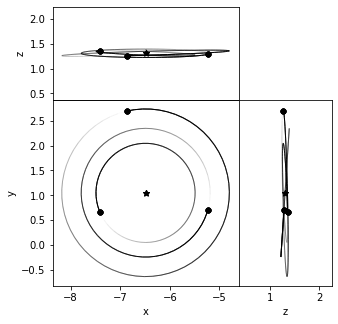

In [21]:
# visualize system after integration
op_set = rebound.OrbitPlotSet(sim)

## Plot simulation results

In [67]:
# relative change in semimajor axis (percent)
print((b_as[0] - b_as[-1]) / b_as[0] * 100)
print((c_as[0] - c_as[-1]) / c_as[0] * 100)
print((d_as[0] - d_as[-1]) / d_as[0] * 100)

0.0010355815844077733
-0.000403678242348282
-0.0011545992223163492


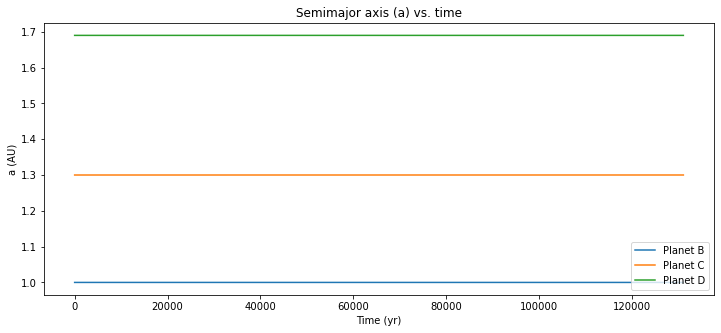

Max Planet B eccentricity: 0.0022647706732332297
Max Planet C eccentricity: 0.0031843711104428555
Max Planet D eccentricity: 0.0018690214405808132


In [23]:
# check that semimajor axes/eccentricities aren't wandering
fig = plt.figure(figsize=(12,5))

plt.plot(times, b_as, label='Planet B')
plt.plot(times, c_as, label='Planet C')
plt.plot(times, d_as, label='Planet D')

plt.xlabel('Time (yr)')
plt.ylabel('a (AU)')

plt.title('Semimajor axis (a) vs. time')
plt.legend(loc='lower right')
plt.show()


print(f'Max Planet B eccentricity: {max(b_es)}')
print(f'Max Planet C eccentricity: {max(c_es)}')
print(f'Max Planet D eccentricity: {max(d_es)}')

# fig = plt.figure(figsize=(16,3))
# plt.plot(times, b_es, lw=1, label='Planet B')
# plt.plot(times, c_es, lw=1, label='Planet C')
# plt.plot(times, d_es, lw=1, label='Planet D')

# plt.xlabel('Time (yr)')
# plt.ylabel('Eccentricity (e)')

# plt.title('Eccentricity (e) vs. time')
# plt.legend(loc='lower right')
# plt.show()

In [24]:
# convert inclinations from radians to degrees
b_incs_deg = b_incs_rad * (180 / np.pi)
c_incs_deg = c_incs_rad * (180 / np.pi)
d_incs_deg = d_incs_rad * (180 / np.pi)
b_complex_incs_deg = b_complex_incs_rad * (180 / np.pi)
c_complex_incs_deg = c_complex_incs_rad * (180 / np.pi)
d_complex_incs_deg = d_complex_incs_rad * (180 / np.pi)

# save data
file_path = f'cmplx_incs_alpha=%.3f_t=%.1E_yrs.pkl' % (alpha, tmax)
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, b_complex_incs_deg, c_complex_incs_deg, d_complex_incs_deg), f)

In [ ]:
# load_data = False

# if load_data:    
#     tmax = 8192
#     file_path = f'bcd_complex_incs_%.1E_yrs.pkl' % tmax

#     ## open old data files
#     with lzma.open(file_path, 'rb') as f:
#         times, b_complex_incs_deg, c_complex_incs_deg, d_complex_incs_deg = pickle.load(f)

#     b_incs_deg = np.abs(b_complex_incs_deg)
#     c_incs_deg = np.abs(c_complex_incs_deg)
#     d_incs_deg = np.abs(d_complex_incs_deg)

# fig = plt.figure(figsize=(14,5))

# plt.plot(times, b_incs_deg, label='Planet B')
# plt.plot(times, c_incs_deg, label='Planet C')
# plt.plot(times, d_incs_deg, label='Planet D')

# plt.xlabel('Time (yr)')
# plt.ylabel('Inclination')
# plt.title('Physical inclination')

# plt.legend(loc='lower right')
# plt.show()

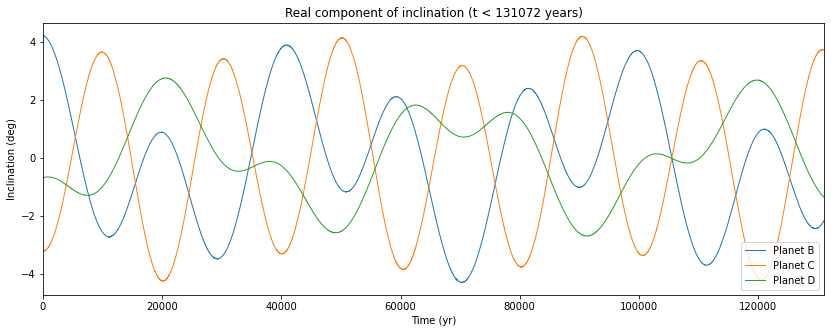

In [25]:
fig = plt.figure(figsize=(14,5))

xlim = tmax

plt.plot(times, b_complex_incs_deg.real, lw=1, label='Planet B')
plt.plot(times, c_complex_incs_deg.real, lw=1, label='Planet C')
plt.plot(times, d_complex_incs_deg.real, lw=1, label='Planet D')

plt.xlabel('Time (yr)')
plt.xlim(0, xlim)
plt.ylabel('Inclination (deg)')
plt.title(f'Real component of inclination (t < {xlim} years)')

plt.legend(loc='lower right')
plt.show()

In [24]:
# temp_range = slice(0, 500)

# plt.figure(figsize=(4,4))

# plt.scatter(b_complex_incs_deg.real[temp_range], \
#             b_complex_incs_deg.imag[temp_range], s=4, label='b')
# plt.scatter(c_complex_incs_deg.real[temp_range], \
#             c_complex_incs_deg.imag[temp_range], s=4, label='c')
# plt.scatter(d_complex_incs_deg.real[temp_range], \
#             d_complex_incs_deg.imag[temp_range], s=4, label='d')

# plt.xlabel('real')
# plt.ylabel('imag')
# plt.title('Complex Incs in Complex Plane')
# plt.legend(loc='upper right')
# plt.show()

## Run FFT (and interpolation)

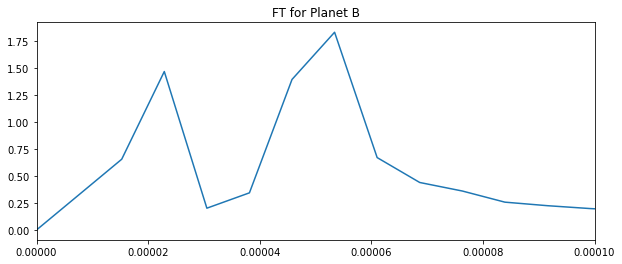

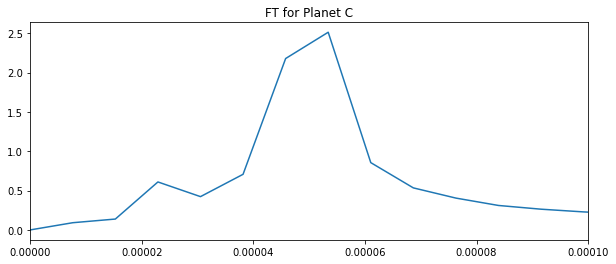

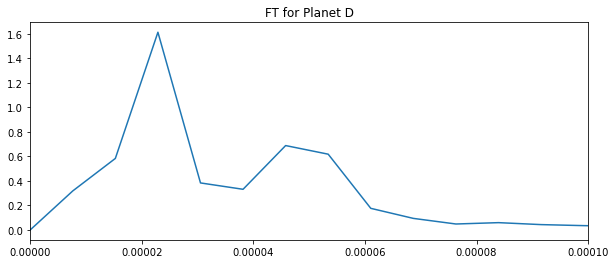

Planet B freqs (yr^-1):  [5.34e-05 2.29e-05]
Planet B periods (yr):  [18724.571 43690.667]
Planet B amplitudes (deg):  [1.835182 1.470407]

Planet C freqs (yr^-1):  [5.34e-05 4.58e-05]
Planet C periods (yr):  [18724.571 21845.333]
Planet C amplitudes (deg):  [2.511894 2.177923]

Planet D freqs (yr^-1):  [2.29e-05 4.58e-05]
Planet D periods (yr):  [43690.667 21845.333]
Planet D amplitudes (deg):  [1.613922 0.688723]


In [26]:
def quad_fn(coeffs, x):
    '''
    Given the coefficients of a quadratic polynomial f(x), return f(x).
    
    PARAMETERS
    ----------
    coeffs: 3-element list containing the quadratic's coefficients, 
    highest power first.
    x: the value at which to evaluate f(x).
    
    '''
    
    a, b, c = coeffs
    
    return a * x**2 + b * x + c

def FFT_freq_amp(incs, planet_name, quad_interp=False):
    '''
    Given a time series (incs) representing either component of complex inclination, 
    return the mode frequencies and amplitudes of the time series. 
    (Might include an option to apply quadratic interpolation around the FFT's peaks.)
    
    NOTE: This implementation is for 3 planets.
        
    ARGUMENTS
    ---------
    incs: time series of either the real or imag component of a complex inclination series
    planet_name: string representing planet name (used in plots)
    quad_interp: if True, uses quadratic interpolation to improve the result
    of low-resolution FFTs; default is False
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.figure(figsize=(10,4))
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 1e-4)
    plt.title('FT for ' + planet_name)
    plt.show()
    
    # get locations of the FFT's two peaks
    sorted_ind_arr = np.argsort(-yf_scaled) # indices to sort yf_scaled in decreasing order
    mode_amp1 = yf_scaled[sorted_ind_arr[0]]
    mode_amp2 = yf_scaled[sorted_ind_arr[1]]
    mode_freq1 = xf[sorted_ind_arr[0]]
    mode_freq2 = xf[sorted_ind_arr[1]]
    
    # run quadratic interpolation on the FFT
    if quad_interp:
        raise RuntimeError("Error: haven't implemented ")
#         x_vals = [xf[np.argmax(yf) - 1], xf[np.argmax(yf)], xf[np.argmax(yf) + 1]]
#         y_vals = np.abs([yf[np.argmax(yf) - 1], yf[np.argmax(yf)], yf[np.argmax(yf) + 1]])
#         y_vals_scaled = 2 / num_steps * np.abs(y_vals)

#         # get coefficients of the interpolated quadratic function
#         coeffs = np.polyfit(x_vals, y_vals_scaled, deg=2)
#         a, b, c = coeffs

#         # get mode freq and amplitude
#         mode_f = - b / (2*a) # peak of the quadratic function
#         mode_amp = quad_fn(coeffs, mode_f)

#         # return period (years) and amplitude
#         return mode_f, mode_amp

    # (result from no quadratic interpolation)
    # return freq (years^-1) and amplitude (degrees)
    return [mode_freq1, mode_freq2], [mode_amp1, mode_amp2]

b_series = b_complex_incs_deg.real
c_series = c_complex_incs_deg.real
d_series = d_complex_incs_deg.real

use_interp = False

b_freqs = np.zeros([2])
b_amps = np.zeros([2])
b_freqs, b_amps = FFT_freq_amp(b_series, 'Planet B', quad_interp=use_interp)
b_periods = [1/freq for freq in b_freqs] # years

c_freqs = np.zeros([2])
c_amps = np.zeros([2])
c_freqs, c_amps = FFT_freq_amp(c_series, 'Planet C', quad_interp=use_interp)
c_periods = [1/freq for freq in c_freqs] # years

d_freqs = np.zeros([2])
d_amps = np.zeros([2])
d_freqs, d_amps = FFT_freq_amp(d_series, 'Planet D', quad_interp=use_interp)
d_periods = [1/freq for freq in d_freqs] # years

if use_interp:
    print('WITH QUADRATIC INTERPOLATION:')
print(f'Planet B freqs (yr^-1): ', np.round(b_freqs,7))
print(f'Planet B periods (yr): ', np.round(b_periods,3))
print(f'Planet B amplitudes (deg): ', np.round(b_amps,6))
print()
print(f'Planet C freqs (yr^-1): ', np.round(c_freqs,7))
print(f'Planet C periods (yr): ', np.round(c_periods,3))
print(f'Planet C amplitudes (deg): ', np.round(c_amps,6))
print()
print(f'Planet D freqs (yr^-1): ', np.round(d_freqs,7))
print(f'Planet D periods (yr): ', np.round(d_periods,3))
print(f'Planet D amplitudes (deg): ', np.round(d_amps,6))

### Write down mode amplitude vectors

NOTE: I'm determining the mode frequencies by eye.

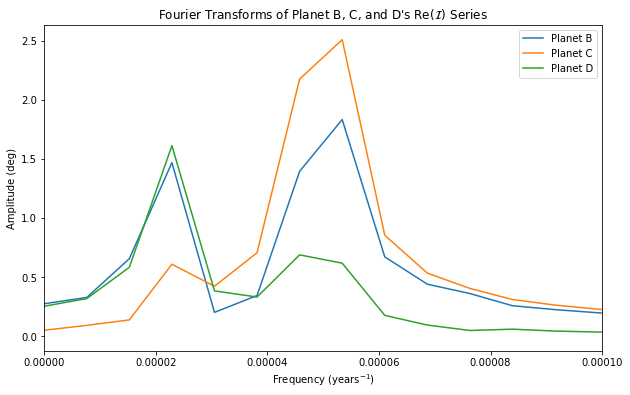

In [35]:
b_fft = 2 / num_steps * np.abs(fft.fft(b_complex_incs_deg.real))
b_fft = b_fft[:N//2]
c_fft = 2 / num_steps * np.abs(fft.fft(c_complex_incs_deg.real))
c_fft = c_fft[:N//2]
d_fft = 2 / num_steps * np.abs(fft.fft(d_complex_incs_deg.real))
d_fft = d_fft[:N//2]

g1_num = b_freqs[1]
g2_num = b_freqs[0]
freqs = fft.fftfreq(num_steps, tstep)[:N//2]
# index of mode frequency in freqs array
g1_ind = np.squeeze(np.where(freqs == g1_num))
g2_ind = np.squeeze(np.where(freqs == g2_num))

# mode_amp = np.array([b_fft[max_freq], c_fft[max_freq]])
# mode_amp = mode_amp / np.linalg.norm(mode_amp)
# print(f'Mode amp: {mode_amp}')

# plot FTs
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')

plt.plot(freqs, b_fft, label='Planet B')
plt.plot(freqs, c_fft, label='Planet C')
plt.plot(freqs, d_fft, label='Planet D')

plt.xlabel('Frequency (years$^{-1}$)')
plt.xlim(0, 1e-4)
plt.ylabel('Amplitude (deg)')
plt.title("Fourier Transforms of Planet B, C, and D's Re($\mathcal{I}$) Series")
plt.legend()

# fig_path = "Figures/BCD_FTs.png"
# plt.savefig(fig_path, bbox_inches='tight')
plt.show()

## `curve_fit` with FFT as initial guess

In [41]:
def cos_func(x, a, b, c, d):
    '''
    Returns a cosine function. 
    
    '''
    
    return a * np.cos(b * x + c) + d

def test_func(x, a1, b1, c1, d1, a2, b2, c2, d2):
    '''
    Returns a sum of 2 cosine functions. 
    
    '''
    
    return cos_func(x, a1, b1, c1, d1) + cos_func(x, a2, b2, c2, d2)

# Given our FFT results as an initial guess, use curve_fit to infer the parameters
# of Planet B's complex inclination series (real component).

guess_b = [b_fft[g1_ind], (2*np.pi)*g1_num, 0, 0, \
          b_fft[g2_ind], (2*np.pi)*g2_num, 0, 0]
params, params_covariance = optimize.curve_fit(test_func, times, b_series, \
                                               p0=guess_b)
a1_B, b1_B, c1_B, d1_B, a2_B, b2_B, c2_B, d2_B = params

print('Fitted params (B):')
print(params)

# Fit parameters for Planet C.
guess_c = [c_fft[g1_ind], (2*np.pi)*g1_num, 0, 0, \
          c_fft[g2_ind], (2*np.pi)*g2_num, 0, 0]
params, params_covariance = optimize.curve_fit(test_func, times, c_series, \
                                               p0=guess_c)
a1_C, b1_C, c1_C, d1_C, a2_C, b2_C, c2_C, d2_C = params

print('Fitted params (C):')
print(params)

# Fit parameters for Planet D.
guess_d = [d_fft[g1_ind], b1_C, 0, 0, \
          d_fft[g2_ind], b2_C, 0, 0] # use the freqs from Planet C
params, params_covariance = optimize.curve_fit(test_func, times, d_series, \
                                               p0=guess_d)
a1_D, b1_D, c1_D, d1_D, a2_D, b2_D, c2_D, d2_D = params

print('Fitted params (D):')
print(params)

Fitted params (B):
[ 1.78443772e+00  1.31433360e-04  2.59866115e-01  2.43950908e+03
  2.55920932e+00  3.12654769e-04 -4.21003288e-03 -2.43951036e+03]
Fitted params (C):
[ 5.16124998e-01  1.31040535e-04  2.93230100e-01 -3.26773490e+03
  3.68627144e+00  3.12640270e-04  3.13869202e+00  3.26773612e+03]
Fitted params (D):
[-1.80026688e+00  1.31338702e-04  2.67836358e-01  1.18924274e+04
  1.00886953e+00  3.12611746e-04 -3.21021004e-04 -1.18924274e+04]


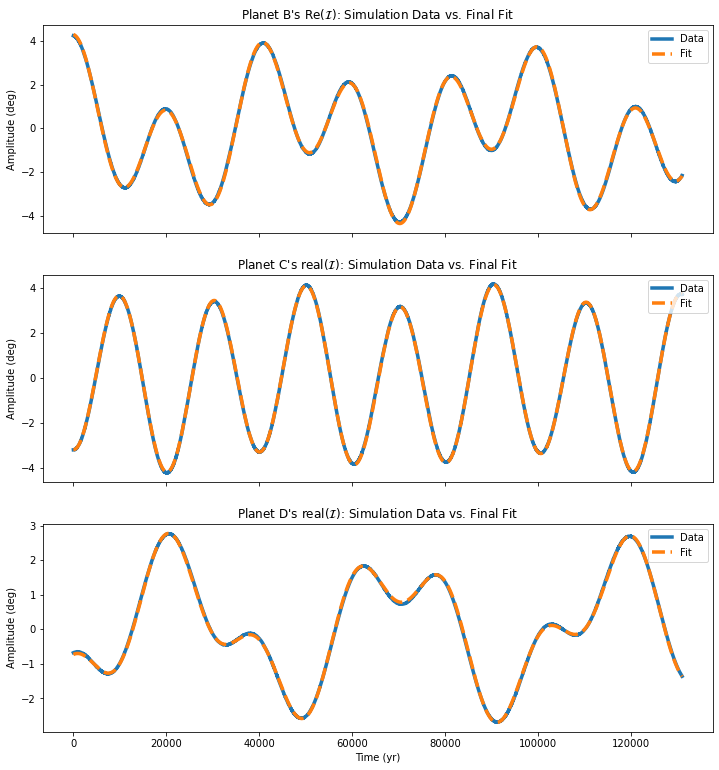

In [47]:
## Plot data vs. curve_fit results.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,13))
fig.patch.set_facecolor('white')

# Planet B
fitted_b_series = test_func(times, a1_B, b1_B, c1_B, d1_B, \
                            a2_B, b2_B, c2_B, d2_B)
ax1.plot(times, b_series, lw='3.5', label='Data')
ax1.plot(times, fitted_b_series, '--', lw='3.5', label='Fit')
ax1.set_ylabel('Amplitude (deg)')
ax1.set_title("Planet B's Re($\mathcal{I}$): Simulation Data vs. Final Fit")
ax1.legend(loc='upper right')

# Planet C
fitted_c_series = test_func(times, a1_C, b1_C, c1_C, d1_C, \
                            a2_C, b2_C, c2_C, d2_C)
ax2.plot(times, c_series, lw='3.5', label='Data')
ax2.plot(times, fitted_c_series, '--', lw='3.5', label='Fit')
#ax2.set_xlabel('Time (yr)')
ax2.set_ylabel('Amplitude (deg)')
ax2.set_title("Planet C's real($\mathcal{I}$): Simulation Data vs. Final Fit")
ax2.legend(loc='upper right')

# Planet D
fitted_d_series = test_func(times, a1_D, b1_D, c1_D, d1_D, \
                            a2_D, b2_D, c2_D, d2_D)
ax3.plot(times, d_series, lw='3.5', label='Data')
ax3.plot(times, fitted_d_series, '--', lw='3.5', label='Fit')
ax3.set_xlabel('Time (yr)')
ax3.set_ylabel('Amplitude (deg)')
ax3.set_title("Planet D's real($\mathcal{I}$): Simulation Data vs. Final Fit")
ax3.legend(loc='upper right')

# fig_path = "Figures/BCD_data_vs_curvefit"
# plt.savefig(fig_path, bbox_inches='tight')
plt.show()

# Analytic formula

In [12]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or u.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [13]:
a_b = sim.particles[1].a * u.au
a_c = sim.particles[2].a * u.au
a_d = sim.particles[3].a * u.au

M_star = sim.particles[0].m * u.M_sun
m_b = sim.particles[1].m * u.M_sun
m_c = sim.particles[2].m * u.M_sun
m_d = sim.particles[3].m * u.M_sun

planet_inds = ['b', 'c', 'd']

# calculate omega_jk values in yr^-1 (but without the unit)
# format: omega_jk = mode_freq(a_j, a_k, m_k, M_star).to(u.yr**-1).value
for j in planet_inds:
    for k in planet_inds:
        if (j == k): continue
        exec('omega_' + j + k + ' = ' + \
             'mode_freq(a_' + j + ', a_' + k +', m_' + k +', M_star).to(u.yr**-1).value')

The below cell gets the eigenvalues of the matrix in Eq. A1 of Su & Lai 2022.

In [15]:
mat = np.array([
    [-omega_bc - omega_bd, omega_bc, omega_bd],
    [omega_cb, -omega_cb - omega_cd, omega_cd],
    [omega_db, omega_dc, -omega_db - omega_dc]
])

eigs, eigvs = np.linalg.eig(mat)
prec_freqs = eigs[np.where(np.abs(eigs) > 1e-10)]
prec_eigvs = eigvs[:, np.where(np.abs(eigs) > 1e-10)]
prec_eigvs = np.squeeze(prec_eigvs).T # reshape to (2,3), ie each row is an eigv
zero_mode_ind = np.where(np.abs(eigs) < 1e-10)[0] # index of mode w/ frequency=0

g_1, g_2 = -prec_freqs

In [16]:
print(f'Period 1: {np.round(2 * np.pi / g_1, 3)} years')
print(f'Period 2: {np.round(2 * np.pi / g_2, 3)} years')
print(f'Non-zero mode frequencies: {-prec_freqs}')

Period 1: 18029.652 years
Period 2: 42395.273 years
Non-zero mode frequencies: [0.00034849 0.0001482 ]


In [17]:
# check that eigenvalues and eigenvectors match
print(f"Matrix \"divided\" by eigenvector 1: {np.matmul(mat, prec_eigvs[0]) / prec_eigvs[0]}")
print(f"Matrix \"divided\" by eigenvector 2: {np.matmul(mat, prec_eigvs[1]) / prec_eigvs[1]}")
print(f'Eigenvalues: {eigs}')

Matrix "divided" by eigenvector 1: [-0.00034849 -0.00034849 -0.00034849]
Matrix "divided" by eigenvector 2: [-0.0001482 -0.0001482 -0.0001482]
Eigenvalues: [-3.48491762e-04 -1.48204856e-04  1.38023295e-20]


## Mode amplitudes

(taken from two_planet notebook; need to copy-paste equations here + haven't double-checked them so the result may be wrong)

In [18]:
def get_mode_amps(complex_inc_0, eigvs, zero_mode_ind):
    '''
    Given the initial complex inclination vector inc_0 and the set of 
    eigenvectors (eigvs) for a system, compute the mode amplitudes 
    (which are the projections of inc_0 onto the eigenvectors). NOTE: In the below
    calculation, the eigenvector with eigenvalue 0 is set to the zero vector.
    (The index of this eigenvector is given by zero_mode_ind.)
    
    Let n be the number of planets. inc_0 has shape (n,), and eigvs has shape
    (n, n), where the columns (i.e. eigvs[:,i]) are the eigenvectors. The output 
    will have shape (n, n), and the ith column corresponds to mode amplitude i.
    (The column at A_vecs[:,zero_mod_ind] will be the zero vector.)
    
    
    '''
    
    n = len(complex_inc_0)
    complex_inc_0 = np.expand_dims(complex_inc_0, axis=1) # change shape to (n, 1)
    eigvs[:,zero_mode_ind] = np.zeros((n, 1))
    
    scalars = np.matmul(np.conj(complex_inc_0.T), eigvs) # complex inner product 
    diag_mat = np.zeros((n,n), dtype=complex)
    np.fill_diagonal(diag_mat, scalars)
    A_vecs = 1j * np.matmul(eigvs, diag_mat)
    
    print(f'complex_inc_0.T: {complex_inc_0}')
    print(f'scalars: {scalars}')
    print(f'diag_mat: {diag_mat}')
    
    return A_vecs

In [48]:
temp_i = 0
inc_0_temp = np.asarray([b_complex_incs_deg[temp_i], c_complex_incs_deg[temp_i], d_complex_incs_deg[temp_i]])
mode_amps = get_mode_amps(inc_0_temp, eigvs, zero_mode_ind)
print('Mode amplitudes:')
print(mode_amps)
print('Magnitudes of mode amplitudes:')
print(np.abs(mode_amps))

complex_inc_0.T: [[ 4.23020638-0.47409092j]
 [-3.20209436-0.11406278j]
 [-0.67663436+0.45941669j]]
scalars: [[-4.78966189-0.0766252j   2.62672422+0.66864674j  0.        +0.j        ]]
diag_mat: [[-4.78966189-0.0766252j   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          2.62672422+0.66864674j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j        ]]
Mode amplitudes:
[[-0.04301256+2.68861432j -0.45190225+1.77526117j  0.        +0.j        ]
 [ 0.06125737-3.8290547j  -0.14783805+0.58076971j  0.        +0.j        ]
 [-0.01639744+1.02496546j  0.47012416-1.84684445j  0.        +0.j        ]]
Magnitudes of mode amplitudes:
[[2.68895835 1.8318755  0.        ]
 [3.82954467 0.59929087 0.        ]
 [1.02509661 1.90574163 0.        ]]
